In [20]:
#!pip install calmap

You should consider upgrading via the 'C:\Users\gonca\anaconda3\python.exe -m pip install --upgrade pip' command.


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV, RidgeCV, LogisticRegression, LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, RobustScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from datetime import datetime
import calmap
import warnings
warnings.filterwarnings('ignore')

### Functions

In [4]:
def find_missing(df):
    missing_col = df.columns[df.isna().sum()>0]
    col_missing_val = df[missing_col].isna().sum().sort_values(ascending=False)
    per_missing_val = (df[missing_col].isna().sum()/df.shape[0]*100).sort_values(ascending=False)
    missing_df = pd.DataFrame(col_missing_val,columns=['missing_number'])
    missing_df['missing_percentage']=per_missing_val
    print('Number of columns with missing data:',missing_df.shape[0])
    return missing_df

## Load and first analysis of the dataset

In [69]:
#loading the Bookings dataset
data = pd.read_csv(r'C:\Users\gonca\Documents\BC2_Predict_Cancellations\data\H2.csv') 
data.head()

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,...,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate
0,0,6,2015,July,27,1,0,2,1,0.0,...,No Deposit,6,NULL,0,Transient,0.0,0,0,Check-Out,2015-07-03
1,1,88,2015,July,27,1,0,4,2,0.0,...,No Deposit,9,NULL,0,Transient,76.5,0,1,Canceled,2015-07-01
2,1,65,2015,July,27,1,0,4,1,0.0,...,No Deposit,9,NULL,0,Transient,68.0,0,1,Canceled,2015-04-30
3,1,92,2015,July,27,1,2,4,2,0.0,...,No Deposit,9,NULL,0,Transient,76.5,0,2,Canceled,2015-06-23
4,1,100,2015,July,27,2,0,2,2,0.0,...,No Deposit,9,NULL,0,Transient,76.5,0,1,Canceled,2015-04-02


In [70]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79330 entries, 0 to 79329
Data columns (total 31 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   IsCanceled                   79330 non-null  int64  
 1   LeadTime                     79330 non-null  int64  
 2   ArrivalDateYear              79330 non-null  int64  
 3   ArrivalDateMonth             79330 non-null  object 
 4   ArrivalDateWeekNumber        79330 non-null  int64  
 5   ArrivalDateDayOfMonth        79330 non-null  int64  
 6   StaysInWeekendNights         79330 non-null  int64  
 7   StaysInWeekNights            79330 non-null  int64  
 8   Adults                       79330 non-null  int64  
 9   Children                     79326 non-null  float64
 10  Babies                       79330 non-null  int64  
 11  Meal                         79330 non-null  object 
 12  Country                      79306 non-null  object 
 13  MarketSegment   

In [74]:
#Country shouldn't be used for analysis as its quality is dependent on chek-in
data = data.drop(['Country'], axis=1)

In [75]:
# Cheecking for duplicates
data.duplicated().sum()


27294

The dataset that we are using had already some pre-procecing with some imputations, so after analysing the data we conclude that the duplicated values are coicidences and not real duplicated enteries 

In [76]:
find_missing(data)

Number of columns with missing data: 1


,missing_number,missing_percentage
Children,4,0.005042


In [13]:
#criar função para quando der missing value no children substituir por 0

In [20]:
Cancelations = data['IsCanceled'].tolist()
print(Cancelations.count(1), 'canceled')
print(Cancelations.count(0), 'not canceled')

33102 canceled
46228 not canceled


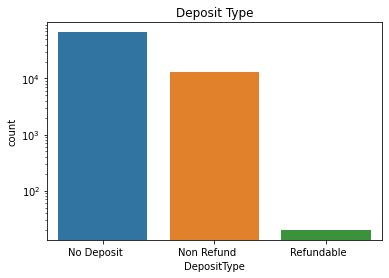

In [22]:
sns.countplot('DepositType', data=data)
plt.title('Deposit Type')
plt.yscale("log")

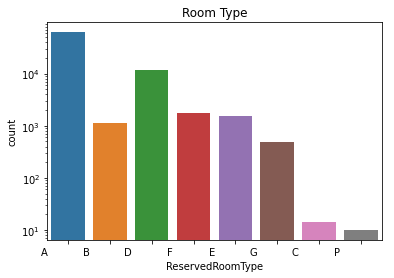

In [23]:
sns.countplot('ReservedRoomType', data=data)
plt.title('Room Type')
plt.yscale("log")

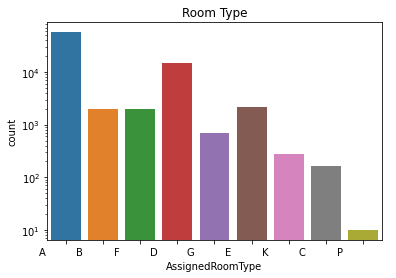

In [24]:
sns.countplot('AssignedRoomType', data=data)
plt.title('Room Type')
plt.yscale("log")

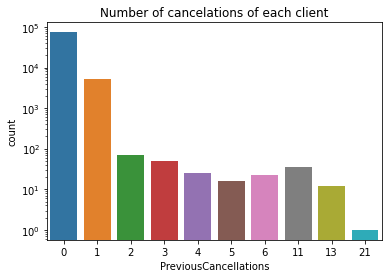

In [25]:
sns.countplot('PreviousCancellations', data=data)
plt.title('Number of cancelations of each client')
plt.yscale("log")

### Feature Engeneering

In [77]:
data['changeroomtype'] = data['AssignedRoomType'] != data['ReservedRoomType']

In [78]:
data[data['changeroomtype'] == True]

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,...,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate,changeroomtype
134,1,0,2015,July,29,15,0,1,2,0.0,...,NULL,NULL,0,Transient,0.00,0,0,Canceled,2015-07-15,True
139,0,0,2015,July,29,15,2,5,2,0.0,...,NULL,NULL,0,Transient,0.00,0,0,Check-Out,2015-07-22,True
237,0,20,2015,July,30,22,0,2,2,0.0,...,1,NULL,0,Transient-Party,62.00,0,0,Check-Out,2015-07-24,True
250,0,20,2015,July,30,22,0,2,2,0.0,...,1,NULL,0,Transient-Party,62.00,0,0,Check-Out,2015-07-24,True
253,0,20,2015,July,30,22,0,2,2,0.0,...,1,NULL,0,Transient-Party,62.00,0,0,Check-Out,2015-07-24,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79213,0,213,2017,August,35,28,1,3,1,0.0,...,19,NULL,0,Transient-Party,104.00,0,0,Check-Out,2017-09-01,True
79214,0,213,2017,August,35,28,1,3,1,0.0,...,19,NULL,0,Transient-Party,104.00,0,0,Check-Out,2017-09-01,True
79229,0,25,2017,August,35,30,0,3,3,0.0,...,9,NULL,0,Transient,236.33,0,3,Check-Out,2017-09-02,True
79237,0,332,2017,August,35,31,0,2,2,0.0,...,9,NULL,0,Transient,170.80,0,2,Check-Out,2017-09-02,True


In [103]:
data.corr().abs()['IsCanceled'].sort_values(ascending=False).head(30)

IsCanceled                     1.000000
LeadTime                       0.309242
TotalOfSpecialRequests         0.293889
changeroomtype                 0.229972
PreviousCancellations          0.166643
BookingChanges                 0.149500
RequiredCarParkingSpaces       0.133096
IsRepeatedGuest                0.065840
DaysInWaitingList              0.060965
PreviousBookingsNotCanceled    0.053134
Adults                         0.053054
StaysInWeekNights              0.048704
Babies                         0.030186
Children                       0.027075
ADR                            0.011965
StaysInWeekendNights           0.007343
ArrivalDateDayOfMonth          0.004331
ArrivalDateYear                0.003004
ArrivalDateWeekNumber          0.001580
Name: IsCanceled, dtype: float64

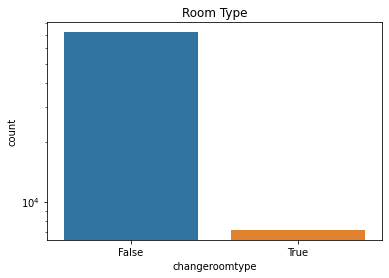

In [79]:
sns.countplot('changeroomtype', data=data)
plt.title('Room Type')
plt.yscale("log")

Create a variable with the arrival date

In [81]:
data['ArrivalDate'] = data['ArrivalDateDayOfMonth'].astype(str)+'/'+data['ArrivalDateMonth']+'/'+data['ArrivalDateYear'].astype(str)

In [82]:
data['ArrivalDate'] = pd.to_datetime(data['ArrivalDate'])

In [83]:
data['ArrivalDate']

0       2015-07-01
1       2015-07-01
2       2015-07-01
3       2015-07-01
4       2015-07-02
           ...    
79325   2017-08-30
79326   2017-08-31
79327   2017-08-31
79328   2017-08-31
79329   2017-08-29
Name: ArrivalDate, Length: 79330, dtype: datetime64[ns]

In [84]:
events = data[['ArrivalDate']]
events['foo'] = events.apply(lambda _: '1', axis=1)
events

,ArrivalDate,foo
0,2015-07-01,1
1,2015-07-01,1
2,2015-07-01,1
3,2015-07-01,1
4,2015-07-02,1
...,...,...
79325,2017-08-30,1
79326,2017-08-31,1
79327,2017-08-31,1
79328,2017-08-31,1


In [85]:
a = events.groupby(['ArrivalDate']).count()
a

,foo
ArrivalDate,
2015-07-01,79
2015-07-02,49
2015-07-03,16
2015-07-04,38
2015-07-05,8
...,...
2017-08-27,107
2017-08-28,133
2017-08-29,90


### Split the metric variables from the non metric one

In [86]:
# Splitting feature into metric and non metric
non_metric_features = ['ArrivalDate','IsCanceled','ArrivalDateYear','ArrivalDateMonth','ArrivalDateWeekNumber','ArrivalDateDayOfMonth','Meal','MarketSegment','DistributionChannel','IsRepeatedGuest','ReservedRoomType','AssignedRoomType','changeroomtype','DepositType','Company','Agent','CustomerType ','RequiredCarParkingSpaces','ArrivalDate','ReservationStatus','ReservationStatusDate']
metric_features = ['LeadTime','StaysInWeekendNights','StaysInWeekNights','Adults','Children','Babies','PreviousCancellations','PreviousBookingsNotCanceled','BookingChanges','DaysInWaitingList','ADR','TotalOfSpecialRequests']
# Checking that no variable is left behind (Só dá true depois de correr a feature Engeneering)
len(metric_features) + len(non_metric_features) == len(data.columns)

False

## One Hot Enconding 

In [113]:
data_ohc = data.copy()

In [114]:
##Non metric features excluding the target variable, the variable created with the date of the reservation completed, the ArrivalDateDayOfMonth, the ArrivalDate and the ReservationStatusDate
non_metric_features = ['ArrivalDateYear','ArrivalDateMonth','ArrivalDateWeekNumber','Meal','MarketSegment','DistributionChannel','IsRepeatedGuest','ReservedRoomType','AssignedRoomType','changeroomtype','DepositType','Company','Agent','CustomerType','RequiredCarParkingSpaces','ReservationStatus']

In [115]:
data_ohc[non_metric_features]

,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,Meal,MarketSegment,DistributionChannel,IsRepeatedGuest,ReservedRoomType,AssignedRoomType,changeroomtype,DepositType,Company,Agent,CustomerType,RequiredCarParkingSpaces,ReservationStatus
0,2015,July,27,HB,Offline TA/TO,TA/TO,0,A,A,False,No Deposit,NULL,6,Transient,0,Check-Out
1,2015,July,27,BB,Online TA,TA/TO,0,A,A,False,No Deposit,NULL,9,Transient,0,Canceled
2,2015,July,27,BB,Online TA,TA/TO,0,A,A,False,No Deposit,NULL,9,Transient,0,Canceled
3,2015,July,27,BB,Online TA,TA/TO,0,A,A,False,No Deposit,NULL,9,Transient,0,Canceled
4,2015,July,27,BB,Online TA,TA/TO,0,A,A,False,No Deposit,NULL,9,Transient,0,Canceled
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79325,2017,August,35,BB,Offline TA/TO,TA/TO,0,A,A,False,No Deposit,NULL,394,Transient,0,Check-Out
79326,2017,August,35,BB,Online TA,TA/TO,0,E,E,False,No Deposit,NULL,9,Transient,0,Check-Out
79327,2017,August,35,BB,Online TA,TA/TO,0,D,D,False,No Deposit,NULL,9,Transient,0,Check-Out
79328,2017,August,35,BB,Online TA,TA/TO,0,A,A,False,No Deposit,NULL,89,Transient,0,Check-Out


In [116]:
# Use OneHotEncoder to encode the categorical features. Get feature names and create a DataFrame 
# with the one-hot encoded categorical features (pass feature names)
ohc = OneHotEncoder(sparse=False, drop="first")
ohc_feat = ohc.fit_transform(data_ohc[non_metric_features])
ohc_feat_names = ohc.get_feature_names()
ohc_df = pd.DataFrame(ohc_feat, index=data_ohc.index, columns=ohc_feat_names)  # Why the index=df_ohc.index?
ohc_df.head(3)

,x0_2016,x0_2017,x1_August,x1_December,x1_February,x1_January,x1_July,x1_June,x1_March,x1_May,...,x12_ 509,x12_ NULL,x13_Group,x13_Transient,x13_Transient-Party,x14_1,x14_2,x14_3,x15_Check-Out,x15_No-Show
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [117]:
# Reassigning data to contain ohc variables
data_ohc = pd.concat([data_ohc.drop(columns=non_metric_features), ohc_df], axis=1)
data_ohc.head(3)

,IsCanceled,LeadTime,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,PreviousCancellations,PreviousBookingsNotCanceled,...,x12_ 509,x12_ NULL,x13_Group,x13_Transient,x13_Transient-Party,x14_1,x14_2,x14_3,x15_Check-Out,x15_No-Show
0,0,6,1,0,2,1,0.0,0,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,88,1,0,4,2,0.0,0,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,65,1,0,4,1,0.0,0,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


##  2. Feature Selection
In feature selection several different models contribute with different perspectives, this said, our methodology regarding feature selection was to create an artificial collaboration to get the best from each method. 

5 different methods were used, namely correlation with our target variable, rfe, lasso CV, Ridge Regression, and a Decision Tree feature selection for both gini and entropy criterions. We used the best 30 features for all methods, except for the Ridge regression in which we used only the ones that were different than 0. Then counted the times a feature appeared for each method and we applied a threshold. This threshold allowed us to have a good feature selection and to easily manipulate the amount of features we had in our model by just lowering the threshold from minimum 2 methods or to minimum 3 methods required to appear in the final variables for the classification solution.  
- Using Correlation w/ Income
- Using rfe
- Using LassoCV
- Using Ridge CV
- Using DecisionTreeClassifier

In [118]:
# Splitting feature names into groups
i_non_metric_features = data_ohc.select_dtypes(include=['object']).columns
i_metric_features = data_ohc.select_dtypes(exclude=['object']).columns

In [121]:
data_ohc[i_metric_features]

,IsCanceled,LeadTime,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,PreviousCancellations,PreviousBookingsNotCanceled,...,x12_ 509,x12_ NULL,x13_Group,x13_Transient,x13_Transient-Party,x14_1,x14_2,x14_3,x15_Check-Out,x15_No-Show
0,0,6,1,0,2,1,0.0,0,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,88,1,0,4,2,0.0,0,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,65,1,0,4,1,0.0,0,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,92,1,2,4,2,0.0,0,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,100,2,0,2,2,0.0,0,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79325,0,23,30,2,5,2,0.0,0,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
79326,0,102,31,2,5,3,0.0,0,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
79327,0,34,31,2,5,2,0.0,0,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
79328,0,109,31,2,5,2,0.0,0,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [134]:
data = data_ohc[i_metric_features].copy().drop(['IsCanceled'], axis=1)
target = data_ohc['IsCanceled']

In [123]:
top30 = list()

##### Using Correlation w/ IsCanceled

In [ ]:
data_ohc.corr().abs()['IsCanceled'].sort_values(ascending=False).head(30)

In [125]:
top30.append(data_ohc.corr().abs()['IsCanceled'].sort_values(ascending=False).head(30))

##### Using rfe

In [137]:
modelLR = LinearRegression()
rfe = RFE(estimator = modelLR, n_features_to_select = 30)
c = rfe.fit_transform(X = data , y = target)
modelLR.fit(X = X_rfe, y = target)
selected_features = pd.Series(rfe.support_, index = data.columns)
selected_features[selected_features.values==True]

TypeError: invalid type promotion

In [ ]:
top30.append(selected_features[selected_features.values==True].index)

##### Using Lasso Regression

In [130]:
reg = LassoCV()
reg.fit(X = dataforfeature, y = targetforfeature)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(data,target))
coef = pd.Series(reg.coef_, index = data.columns)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

TypeError: invalid type promotion

In [ ]:
top30.append(coef[coef.values!=0].index)

##### Using Ridge Regression

In [38]:
ridge = RidgeCV()
ridge.fit(X = dataforfeature, y = targetforfeature)
#print('The alpha atribute using RidgeCV: %f' %ridge.alpha_)
#print('The score using RidgeCV: %f' %ridge.score(data,target))
coef_ridge = pd.Series(ridge.coef_, index = data.columns)
#coef_ridge.sort_values(ascending=False).head(30)

ValueError: could not convert string to float: 'July'

In [ ]:
top30.append(coef_ridge.sort_values(ascending=False).head(30).index)

##### Using DecisionTreeClassifier

In [41]:
gini_importance = DecisionTreeClassifier().fit(dataforfeature,targetforfeature).feature_importances_
entropy_importance = DecisionTreeClassifier(criterion='entropy').fit(dataforfeature,targetforfeature).feature_importances_

ValueError: could not convert string to float: 'July'

In [ ]:
zippy = pd.DataFrame(zip(gini_importance, entropy_importance), columns = ['gini','entropy'])
zippy['col'] = data.columns
tidy = zippy.melt(id_vars='col').rename(columns=str.title)
tidy.sort_values(['Value'], ascending = False, inplace = True)
plt.figure(figsize=(15,8))
sns.barplot(y='Col', x='Value', hue='Variable', data=tidy.head(60))

In [ ]:
top30.append(tidy.sort_values(['Value'], ascending = False).head(60)['Col'].drop_duplicates().values)

In [ ]:
onlyDT = tidy.sort_values(['Value'], ascending = False).head(60)['Col'].values.tolist()

In [ ]:
onlyDT

##### Final Variables
As the different methods gave different results we will use the fields that appear in more than 1 method



In [43]:
series30 = pd.Series(top30) 

In [ ]:
series30 = pd.Series(top30) 
series30 = series30.explode().value_counts()
onlyDT = tidy.sort_values(['Value'], ascending = False).head(60)['Col'].values.tolist()
DT15 = tidy.sort_values(['Value'], ascending = False).head(30)['Col'].values.tolist()
final_var1 = series30[series30.values>1].index
final_var2 = series30[series30.values>2].index
final_var3 = series30[series30.values>3].index

In [ ]:
sns.barplot(x='index',y=0,data=series30.reset_index().head(10))
plt.xticks(rotation = 'vertical')
plt.ylabel('Number of methods a feature appeared in')
plt.xlabel('Features')
plt.show()